In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

dataset = pd.read_csv('AirPassengers.csv')

In [2]:
dataset.shape

(144, 2)

In [3]:
dataset.head(2)

,Month,AirPassengers
0,1949-01,112
1,1949-02,118


In [4]:
dataset['Month'] = pd.to_datetime(dataset['Month'])
dataset.set_index('Month', inplace=True)

In [5]:
dataset.head(2)

,AirPassengers
Month,
1949-01-01,112
1949-02-01,118


In [6]:
dataset.index.freq = 'MS'
train, test = dataset.iloc[:131, 0], dataset.iloc[131:, 0]

In [7]:
model = ExponentialSmoothing(train, 
                             trend='add', 
                             damped=False, 
                             seasonal='add', 
                             seasonal_periods=12).fit()

In [8]:
holt_pred = model.predict(start=test.index[0], end=test.index[-1])

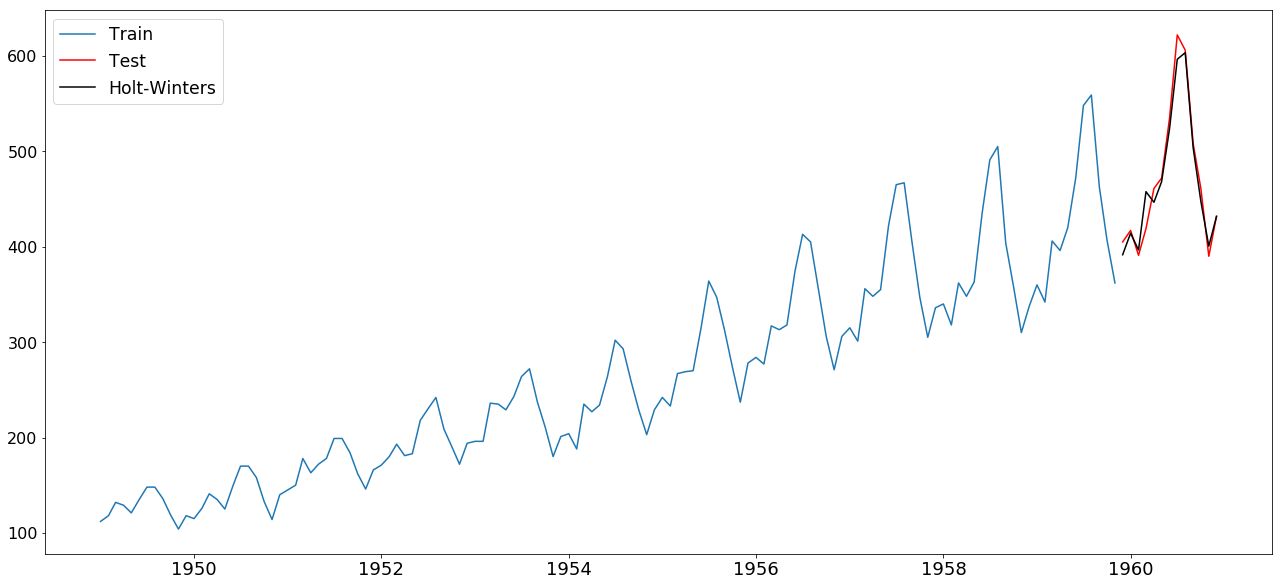

In [9]:
plt.figure(figsize=(22, 10))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='r')
plt.plot(holt_pred.index, holt_pred, label='Holt-Winters', color='k')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

In [10]:
import statsmodels.api as sm
import itertools
import warnings
warnings.filterwarnings("ignore")

In [11]:
def find_best_sarima(train, eval_metric):
    
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

    counter = 0
    myDict = {}
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                counter += 1
                mod = sm.tsa.statespace.SARIMAX(train,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                myDict[counter] = [results.aic, results.bic, param, param_seasonal]

            except:
                continue
                
    dict_to_df = pd.DataFrame.from_dict(myDict,orient='index')
    
    if eval_metric == 'aic':
        best_run = dict_to_df[dict_to_df[0] == dict_to_df[0].min()].index.values
        best_run = best_run[0]
    elif eval_metric == 'bic':
        best_run = dict_to_df[dict_to_df[1] == dict_to_df[1].min()].index.values
        best_run = best_run[0]
            
    model = sm.tsa.statespace.SARIMAX(train,
                                      order=myDict[best_run][2],
                                      seasonal_order=myDict[best_run][3],
                                      enforce_stationarity=False,
                                      enforce_invertibility=False).fit()
    
    best_model = {'model':model, 
                  'aic':model.aic,
                  'bic':model.bic,
                  'order':myDict[best_run][2], 
                  'seasonal_order':myDict[best_run][3]}
    
    return best_model

In [12]:
best = find_best_sarima(train, 'aic')

In [13]:
sarima_pred = best['model'].predict(start=test.index[0], end=test.index[-1], dynamic=True)

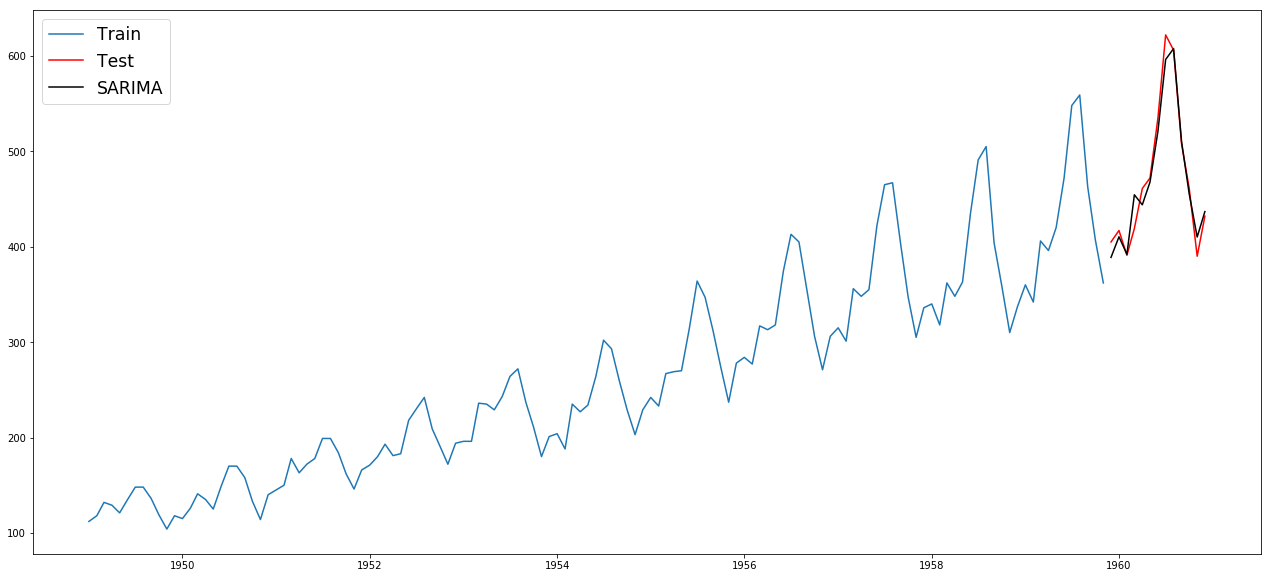

In [14]:
plt.figure(figsize=(22, 10))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='r')
plt.plot(sarima_pred.index, sarima_pred, label='SARIMA', color='k')
plt.legend(loc='best', fontsize='xx-large')
plt.show()

In [23]:
from fbprophet import Prophet
import logging
logging.getLogger().setLevel(logging.ERROR)

In [24]:
df = dataset.reset_index()
df.columns = ['ds', 'y']

In [25]:
prediction_size = 12
train_df = df[:-prediction_size]

In [26]:
m = Prophet(seasonality_mode='multiplicative')
m.fit(train_df)

In [27]:
future = m.make_future_dataframe(periods=prediction_size, freq='M')
forecast = m.predict(future)

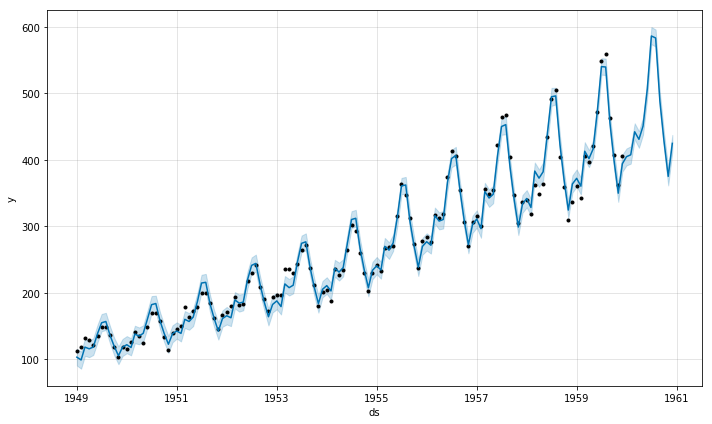

In [28]:
single_plot = m.plot(forecast)

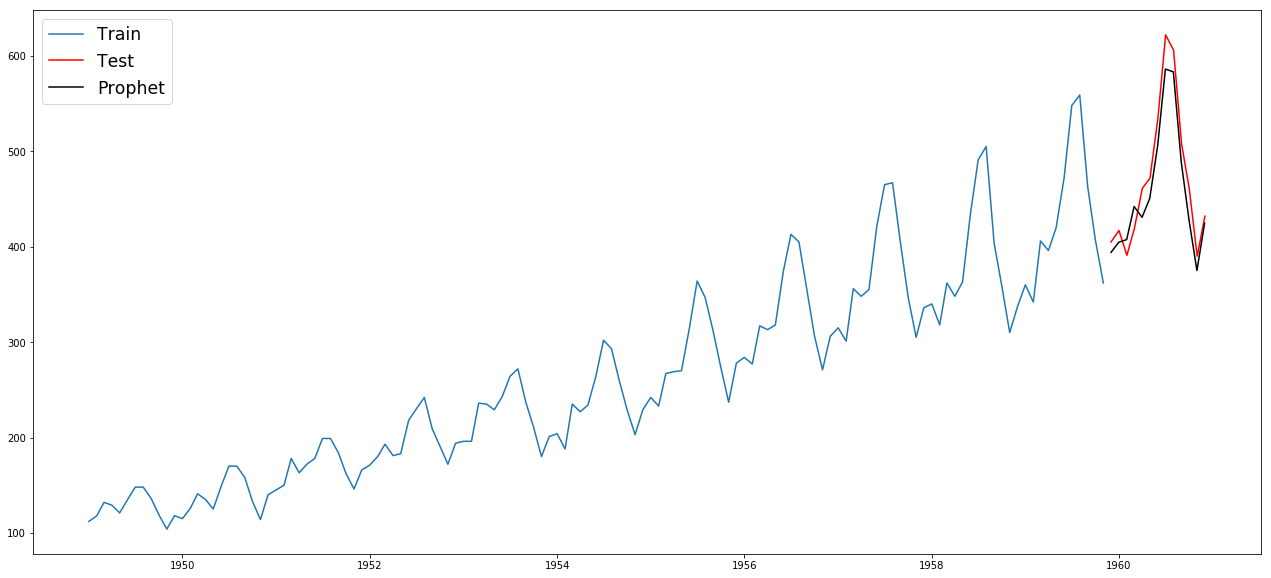

In [29]:
plt.figure(figsize=(22, 10))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='r')
plt.plot(forecast['ds'][131:], forecast['yhat'][131:], label='Prophet', color='k')
plt.legend(loc='best', fontsize='xx-large')
plt.show()

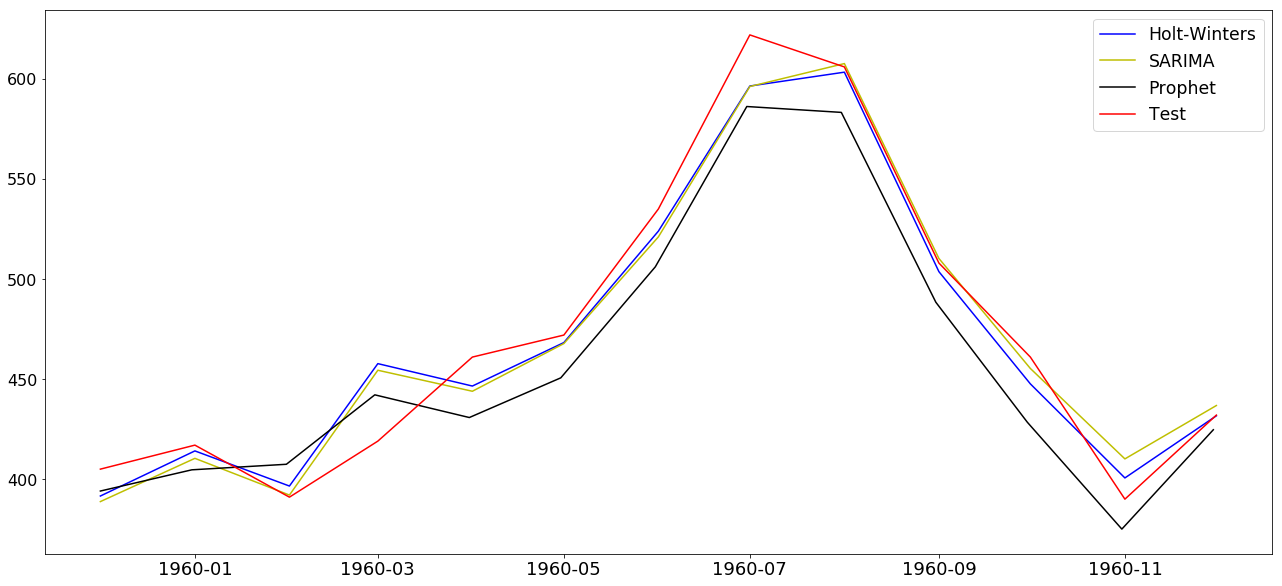

In [30]:
plt.figure(figsize=(22, 10))
plt.plot(holt_pred.index, holt_pred, label='Holt-Winters', color='b')
plt.plot(sarima_pred.index, sarima_pred, label='SARIMA', color='y')
plt.plot(forecast['ds'][131:], forecast['yhat'][131:], label='Prophet', color='k')
plt.plot(test.index, test, label='Test', color='r')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()